# Download models

In [1]:
from app.face_reconstruction.download import load_models

load_models("../models")

Downloading...
From (original): https://drive.google.com/uc?id=18wEUfMNohBJ4K3Ly5wpTejPfDzp-8fI8
From (redirected): https://drive.google.com/uc?id=18wEUfMNohBJ4K3Ly5wpTejPfDzp-8fI8&confirm=t&uuid=3e409114-aad8-4525-8c6d-0427315a1fcb
To: /home/werserk/PycharmProjects/biometrics-hack/notebooks/antelopev2.zip
100%|██████████| 361M/361M [00:04<00:00, 85.4MB/s] 


# Usage

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
from diffusers import (
    StableDiffusionPipeline,
    UNet2DConditionModel,
)

from Arc2Face.arc2face import CLIPTextModelWrapper, project_face_embs

import torch
from insightface.app import FaceAnalysis
from PIL import Image
import numpy as np

# Arc2Face is built upon SD1.5
# The repo below can be used instead of the now deprecated 'runwayml/stable-diffusion-v1-5'

local_model_path = "../models"
base_model = "stable-diffusion-v1-5/stable-diffusion-v1-5"

encoder = CLIPTextModelWrapper.from_pretrained(local_model_path, subfolder="encoder", torch_dtype=torch.float16)
unet = UNet2DConditionModel.from_pretrained(local_model_path, subfolder="arc2face", torch_dtype=torch.float16)
pipeline = StableDiffusionPipeline.from_pretrained(
    base_model, text_encoder=encoder, unet=unet, torch_dtype=torch.float16, safety_checker=None
)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [4]:
from diffusers import DPMSolverMultistepScheduler

pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
pipeline = pipeline.to("cuda")

## Test

In [19]:
app = FaceAnalysis(name="antelopev2", root="../", providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
app.prepare(ctx_id=0, det_size=(640, 640))

img = np.array(Image.open("../assets/examples/max.jpg"))[:, :, ::-1]

faces = app.get(img)
faces = sorted(faces, key=lambda x: (x["bbox"][2] - x["bbox"][0]) * (x["bbox"][3] - x["bbox"][1]))[
    -1
]  # select largest face (if more than one detected)
id_emb = torch.tensor(faces["embedding"], dtype=torch.float16)[None].cuda()
id_emb = id_emb / torch.norm(id_emb, dim=1, keepdim=True)  # normalize embedding
id_emb = project_face_embs(pipeline, id_emb)  # pass through the encoder

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/antelopev2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/antelopev2/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/antelopev2/arcface.onnx recognition ['None', 3, 112, 112] 127.5 127.5
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/antelopev2/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/antelopev2/scrfd_10g_bnkps.onnx detection [1, 3, '?', '?'] 127.5 128.0
set det-size: (640, 640)


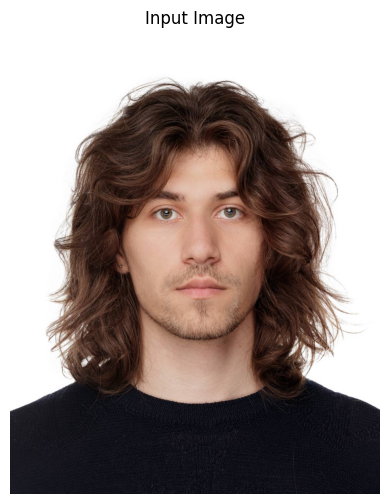

In [22]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(img[:, :, ::-1])
plt.axis("off")
plt.title("Input Image")
plt.show()

  0%|          | 0/25 [00:00<?, ?it/s]

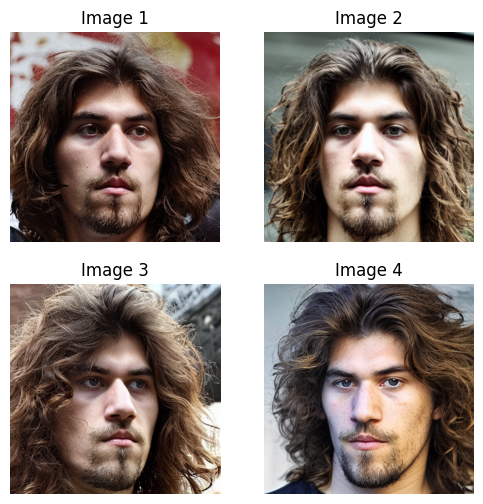

In [30]:
num_images = 4
images = pipeline(prompt_embeds=id_emb, num_inference_steps=25, guidance_scale=3.0, num_images_per_prompt=num_images).images

plt.subplots(2, 2, figsize=(6, 6))
for i in range(num_images):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i])
    plt.axis("off")
    plt.title(f"Image {i + 1}")
plt.show()